In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.util import random_noise

image = cv2.imread("test.jpg", cv2.IMREAD_GRAYSCALE) 

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
image = image / 255.0

# downsample for higher speed
image = (
    image[::4, ::4]
    + image[1::4, ::4]
    + image[::4, 1::4]
    + image[1::4, 1::4]
)
image /= 4.0
height, width = image.shape

# Distort the right half of the image
print("Distorting image...")
distorted = random_noise(image, mode='gaussian', clip=True, var=0.003)
distorted = random_noise(distorted, mode='s&p', amount=0.001) 

Distorting image...


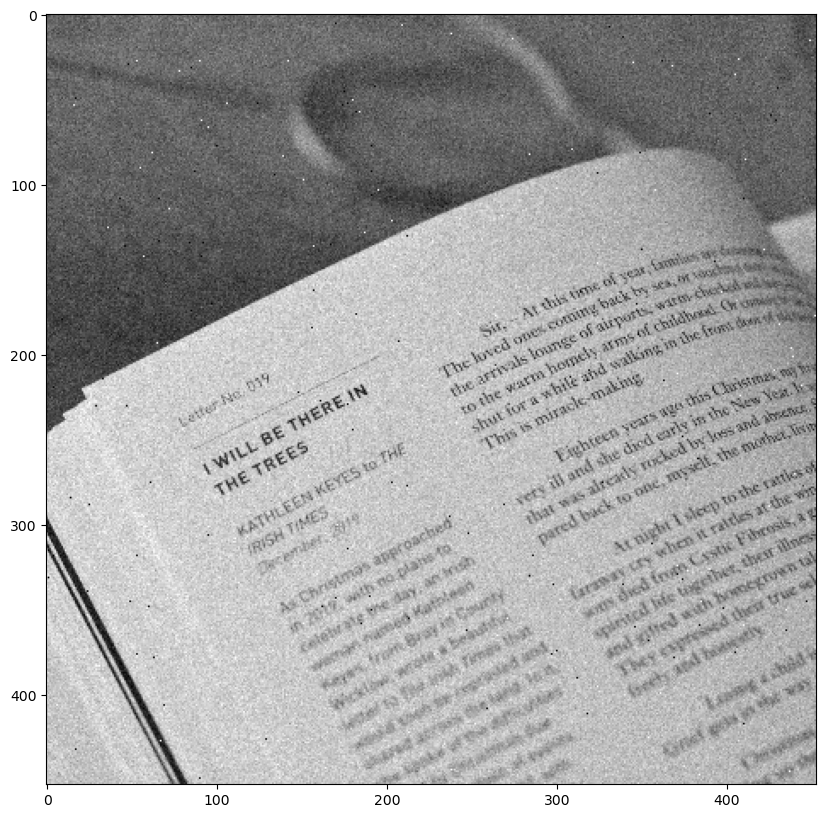

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(distorted, vmin=0, vmax=1, cmap=plt.cm.gray)

In [10]:
patch_size = (7, 7)
data = extract_patches_2d(distorted, patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

In [11]:
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)

V = dico.fit(data).components_

In [12]:
data = extract_patches_2d(distorted, patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

reconstructions = {}

for i in range(2):
    reconstructions[i] = image.copy()
    dico.set_params(transform_algorithm="omp", transform_n_nonzero_coefs=i+1)
    code = dico.transform(data)
    patches = np.dot(code, V)
    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    reconstructions[i] = reconstruct_from_patches_2d(patches, (height, width))

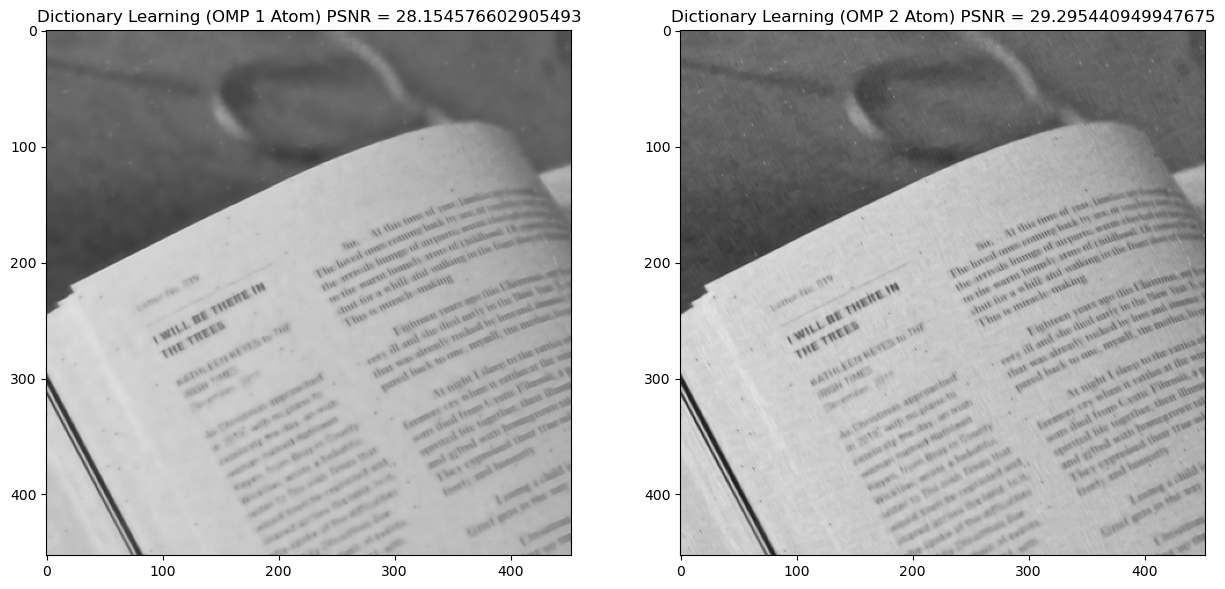

In [18]:
from skimage.metrics import peak_signal_noise_ratio
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(reconstructions[0], vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Dictionary Learning (OMP 1 Atom) PSNR = " + str(peak_signal_noise_ratio(image, reconstructions[0])))
plt.subplot(2, 2, 2)
plt.imshow(reconstructions[1], vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Dictionary Learning (OMP 2 Atom) PSNR = " + str(peak_signal_noise_ratio(image, reconstructions[1])))
plt.savefig("Dict_learning.jpg")
plt.show()